## Malaria Cell Analyzer
by Marsh [ @vbookshelf ] <br>
24 May 2019

<img src="http://malaria.test.woza.work/assets/children.jpg" width="600"></img>

<h5 align="center">Malaria killed more than 261,000 children in 2017</h5>

> *Malaria exacts a massive toll on human health and imposes a heavy social
and economic burden in low and middle income countries, particularly in Sub-Saharan Africa and South Asia. An estimated 219 million people suffered from the disease in 2017 and about 435,000 died. More than 90 percent of the deaths were in Africa, and over 60 percent were among children under 5.<br>*
 ~ [gatesfoundation.org](https://www.gatesfoundation.org/What-We-Do/Global-Health/Malaria)

<hr>

## Introduction

The goal of this kernel is to build a model that can detect malaria parasites in a cell image. The model will analyze a segmented red blood cell image and classify it as either "uninfected" or "parasitized". Once trained the model will be deployed online as a Tensorflow.js web app. 

Malaria diagnosis is currently a manual process. This prototype app is capable of automatically batch analyzing cell images. Therefore, it can help speed up a doctor's diagnostic workflow and reduce diagnostic errors. It can also help medical staff to triage patients by allowing them to quickly assess the severity of each patient's infection.

We will do basic EDA, build a Keras cnn model, do 5 fold cross validation, train the model using all the data and finally evaluate the model on a holdout set.


This is the link to the live app. The html, css, and javascript code is available on Github. I recommend using the latest version of the Chrome browser. When using Safari for example, you may see a message saying that the model is loading but the app may actually be frozen. To see the app in action simply feed it some images from this dataset.

> Web App<br>
> http://malaria.test.woza.work/<br>
> 
> Github<br>
> https://github.com/vbookshelf/Malaria-Cell-Analyzer


Because this app relies on segmented images (Fig. 3 below) this isn't a true end to end solution. In practice a glass slide image has many cells (see Fig. 2 below). A segmentation algorithm will need to be used to isolate (segment out) each cell before it can be fed into this app.

The app is based on Tensorflow.js, a technology that Google developed that allows machine learning models to run in a web browser. You'll notice that the app can process multiple images in about one second. It's fast because the analysis is done locally - on the user's pc or mobile phone. There's no need to upload images to an external server thus ensuring patient privacy and data security.

I hope that this project will help you see how easy it is to build and deploy an Ai based solution.

## Contents

<a href='#Domain_Knowledge'>1. Domain Knowledge</a><br>
<a href='#EDA'>2. EDA</a><br>
<a href='#Create_a_Holdout-Set'>3. Create a Holdout Set</a><br>
<a href='#Train-Test-Split_Model'>4. Train-Test-Split Model</a><br>
<a href='#Error_Analysis'>5. Error Analysis</a><br>
<a href='#Cross_Validation'>6. 5 Fold Cross Validation</a><br>
<a href='#Train'>7. Train the Final Model on all data</a><br>
<a href='#Evaluate'>8. Evaluate the Final Model on the Holdout Set</a><br>
<a href='#Convert'>9. Convert the Final Model to Tensorflow.js</a><br>

<a href='#Citations'>Citations</a><br>
<a href='#Reference_Kernels'>Reference Kernels</a><br>
<a href='#Helpful_Resources'>Helpful Resources</a><br>
<a href='#Conclusion'>Conclusion</a><br>


In [13]:
#
# set seeds to ensure repeatability of results
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np
import os

import cv2
import tensorflow

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import itertools
import shutil
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy


# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [14]:
#
IMAGE_HEIGHT = 96
IMAGE_WIDTH = 96

NUM_HOLDOUT_IMAGES = 200

NUM_EPOCHS = 10
NUM_FOLDS = 5

PADDING = 10
BATCH_SIZE = 10


NUM_FINAL_MODEL_EPOCHS = 10

| <a id='Domain_Knowledge'></a>

## 1. Domain Knowledge

<iframe width="560" height="315" src="https://www.youtube.com/embed/2O3YrdUZQ5U?rel=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>



### Quick Facts

- Malaria is a disease that infects and destroys red blood cells. 
- Doctors analyze thick and thin blood smears to diagnose malaria and determine how severe it is.
- The parasite that causes malaria is called Plasmodium.
- The female Anopheles mosquito is the only mosquito that transmits malaria.


### Background

Microscopic examination of thick and thin blood smears is the easiest and most reliable test for malaria. Blood smears are often taken from a finger prick.

<br>

<img src="http://malaria.test.woza.work/assets/glassslide.jpg" width="400"></img>

<h5 align="center">Fig 1. Microscope and glass slide</h5>

<br>
<br>

<img src="http://malaria.test.woza.work/assets/raw_image.jpg" width="400"></img>

<h5 align="center">Fig 2. Cells seen under a microscope. <br>
Thin blood smear.</h5>

<br>
<br>

<img src="http://malaria.test.woza.work/assets/parasitized.png" width="200"></img>

<h5 align="center">Fig 3. Segmented parasitized cell</h5>

<br>
<br>

*Malaria diagnosis involves the following*:<br>
> - Determine if the malaria parasite is present.
> - Determine the parasite species.
> - Determine parasite density by counting the number of cells that are infected.

<br>

*Thick Blood Smear*<br>

A thick blood smear is a drop of blood on a glass slide. It's used to determine if there are any parasites in the blood. It's a larger blood sample because there could only be a few parasites present so a larger sample is needed to detect them. If no parasites are found the patient will have repeated blood smears every 8 hours for a few of days to confirm that there's no malaria infection.

<br>

*Thin Blood Smear*<br>

A thin blood smear is a drop of blood that's spread over a large area of the glass slide. This blood smear helps doctor's discover what species of parasite is causing the infection.

<br>

*Plasmodium*<br>

This is the parasite that causes malaria. There are many species of Plasmodium. Five species cause malaria - P. vivax, P. ovale, P. malariae, P. knowlesi and P. falciparum. Most deaths are caused by P. falciparum. The other species usually cause a milder form of malaria.

<br>

*Parasitemia*<br>

This is the percentage of red blood cells that are infected by malaria (parasite density). This is computed by counting the number of infected cells visible under a microscope. This number helps doctors determine how severe the disease is. They then prescribe a treatment based on the severity. For example, if a large percentage of blood cells is infected medicine may be given directly into a vein instead of by mouth.

<br>
**Sources**

- uofmhealth.org<br>
https://www.uofmhealth.org/health-library/hw118744

- Wikipedia Malaria<br>
https://en.wikipedia.org/wiki/Malaria

- Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images<br>
https://peerj.com/articles/4568/


| <a id='EDA'></a>

## 2. EDA

### How many files are in each folder?

In [15]:
#
path_uninfected = '../input/cell_images/cell_images/Uninfected'
path_parasitized = '../input/cell_images/cell_images/Parasitized'

uninfected_list = os.listdir(path_uninfected)
parasitized_list = os.listdir(path_parasitized)

print('Uninfected: ', len(uninfected_list))
print('Parasitized: ', len(parasitized_list))

Uninfected:  13780
Parasitized:  13780


The data description says there should be 27,558 cell images i.e. 13779 files per folder. We see that each folder has an extra file. Later we'll check what kind of file this is.

### Let's take a quick look at some images from each class

There are two classes
- uninfected
- parasitized.

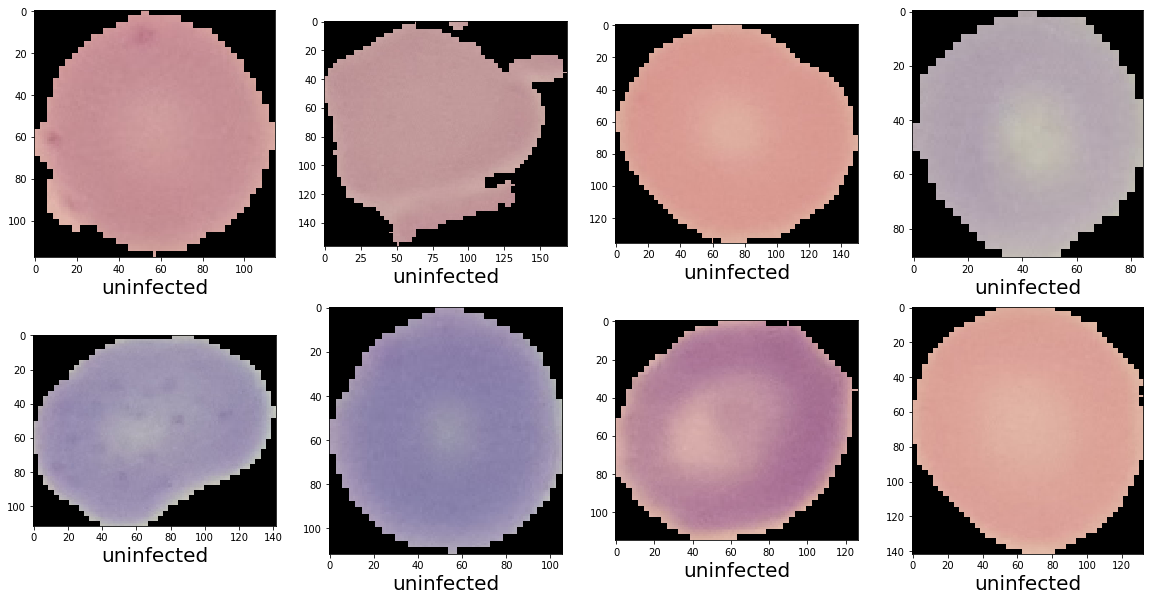

In [16]:
#
path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image = uninfected_list[i]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('uninfected', fontsize=20)

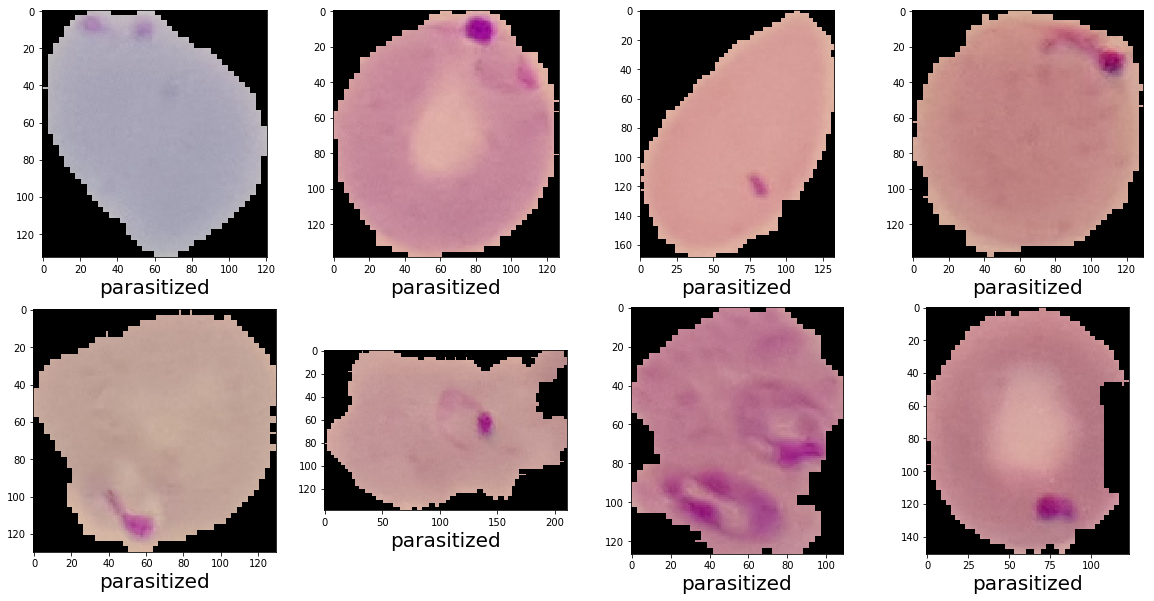

In [17]:
#
path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image = parasitized_list[i]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.xlabel('parasitized', fontsize=20)

### Check if any non image files are in the folders

We see that there are actually 13780 files in each folder and not 13779 as expected. Folders can sometimes contain files that are automatically created during processing. These files can cause errors in the code if we don't know they exist - like the code we wrote above to display the images. Let's check if there are any non image files in the folders. 

In [18]:
#
# Check if any non image files are present in the folder

# sample image name: C140P101ThinF_IMG_20151005_211735_cell_159.png

for item in uninfected_list:
    # split the filename into a list
    file_list = item.split('.')
    
    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Uninfected folder: ', item)

Uninfected folder:  Thumbs.db


In [19]:
#
# Check if any non image files are present in the folder

for item in parasitized_list:
    # split the filename into a list
    file_list = item.split('.')
    
    # check if the file extension is not png
    if file_list[1] != 'png':
        print('Parasitized folder: ',item)

Parasitized folder:  Thumbs.db


We see that each folder has one non image file called Thumbs.db. Now that we know that these non image files exist we will be sure exclude them later.

### Put the image names into dataframes

Here we will create a dataframe called df_combined that includes both uninfected and parasitized images. This new dataframe will have a column showing the target class of each image.

In [20]:
#
# create the dataframe
df_uninfected = pd.DataFrame(uninfected_list, columns=['image_id'])

# remove the non image file
df_uninfected = df_uninfected[df_uninfected['image_id'] != 'Thumbs.db']

# add a target column
df_uninfected['target'] = 0


# create the dataframe
df_parasitized = pd.DataFrame(parasitized_list, columns=['image_id'])

# remove the non image file
df_parasitized = df_parasitized[df_parasitized['image_id'] != 'Thumbs.db']

# add a target column
df_parasitized['target'] = 1

#print(df_uninfected.shape)
#print(df_parasitized.shape)

# Combine the two dataframes

df_combined = pd.concat([df_uninfected, df_parasitized], axis=0).reset_index(drop=True)

#df_combined.shape

In [21]:
df_combined.head()

,image_id,target
0,C39P4thinF_original_IMG_20150622_110435_cell_4...,0
1,C61P22N_ThinF_IMG_20150818_112626_cell_54.png,0
2,C124P85ThinF_IMG_20151002_154846_cell_133.png,0
3,C129P90ThinF_IMG_20151004_134520_cell_60.png,0
4,C177P138NThinF_IMG_20151201_141604_cell_152.png,0


In [22]:
# Check the shape.
# There should be 27558 rows.

df_combined.shape

(27558, 2)

In [23]:
# Check if the image names are unique.
# The output should be 27558

df_combined['image_id'].nunique()

27558

The output above matches the number of rows. This confirms that each image has a unique name. This is important to verify because duplicate image file names will cause errors in the processing code that we will write later.

### What are the image sizes and how many channels does each have?

Here we will add the following info on each image to the df_combined dataframe:

w = width<br>
h = height<br>
c = number of channels<br>
max_pixel_value<br>
min_pixel_value<br>
image_format

In [24]:
#
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    
    path_uninfected = '../input/cell_images/cell_images/Uninfected/'
    path_parasitized = '../input/cell_images/cell_images/Parasitized/'
     
    if file_name in uninfected_list:
        
        path = path_uninfected
        
    else:
        path = path_parasitized
    
    
    image = cv2.imread(path + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    img_format = file_name.split('.')[1]
    output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val, img_format]
    return output

m = np.stack(df_combined['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val', 'image_format'])

df_combined = pd.concat([df_combined,df],axis=1, sort=False)

df_combined.head(10)

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
0,C39P4thinF_original_IMG_20150622_110435_cell_4...,0,136,121,3,222,0,png
1,C61P22N_ThinF_IMG_20150818_112626_cell_54.png,0,118,115,3,227,0,png
2,C124P85ThinF_IMG_20151002_154846_cell_133.png,0,157,169,3,207,0,png
3,C129P90ThinF_IMG_20151004_134520_cell_60.png,0,136,151,3,226,0,png
4,C177P138NThinF_IMG_20151201_141604_cell_152.png,0,91,85,3,199,0,png
5,C164P125ThinF_IMG_20151116_113954_cell_98.png,0,112,142,3,203,0,png
6,C164P125ThinF_IMG_20151116_113651_cell_117.png,0,112,106,3,193,0,png
7,C116P77ThinF_IMG_20150930_171844_cell_14.png,0,115,127,3,230,0,png
8,C129P90ThinF_IMG_20151004_133921_cell_25.png,0,142,133,3,230,0,png
9,C39P4thinF_original_IMG_20150622_105253_cell_1...,0,139,121,3,223,0,png


In [25]:
# Check if all images have 3 channels
df_combined['c'].value_counts()

3    27558
Name: c, dtype: int64

In [26]:
# Check if all images are in png format
df_combined['image_format'].value_counts()

png    27558
Name: image_format, dtype: int64

In [27]:
# Check for all black images
len(df_combined[(df_combined['max_pixel_val'] == 0) & (df_combined['max_pixel_val'] == 0)])

0

In [28]:
# Check for all white images
len(df_combined[(df_combined['max_pixel_val'] == 255) & (df_combined['max_pixel_val'] == 255)])

0

### Display random images from each of the target classes

The images are randomly selected. Therefore, different images will be dispayed each time the code is run. Also you'll see that parasitized images seem to have a blue-ish area that's not as common in uninfected images.

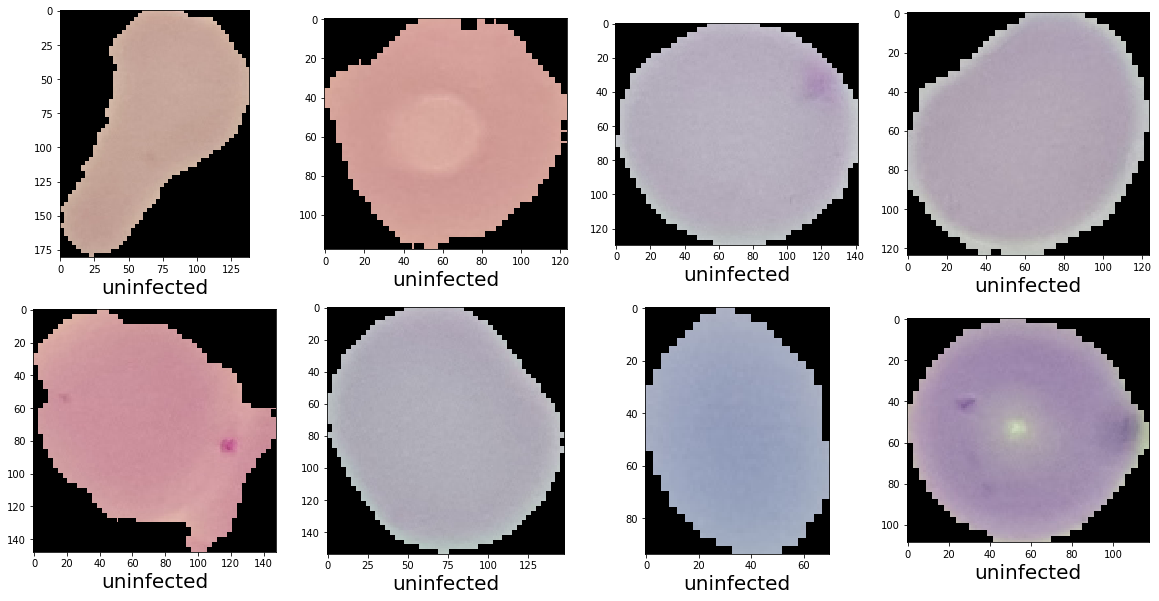

In [29]:
#
path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_uninfected['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('uninfected', fontsize=20)
    


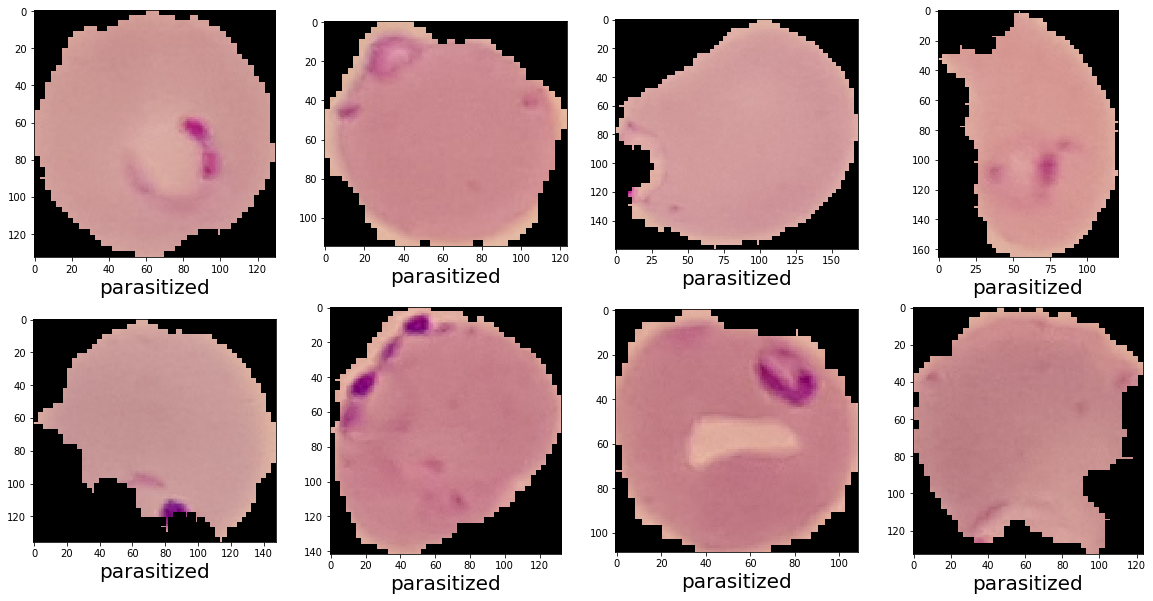

In [30]:
#
path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_parasitized['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.xlabel('parasitized', fontsize=20)

### EDA Summary

- There are 27,558 segmented cell images.
- Each folder contains 13,779 images.
- The images are of various sizes.
- All images are in png format.
- All images have 3 channels i.e. all are colour images.
- There are no all black or all white images.
- The target distribution is balanced i.e. each target class has the same number of images.
- All cells were segmented from thin blood smear slides.
- The parasite specie on all parasitized images is P. falciparum.
- Each folder contains a non image file called Thumbs.db.
- The presence of a blue-ish area inside the cell appears to be a common (but not definitive) indicator that a cell is parasitized.



| <a id='Create_a_Holdout-Set'></a>

## 3. Create a Holdout Set


As we continue to train, validate and modify a model we could over time start to overfit the validation data without realizing it. This means that the model will perform well during training but it will perform poorly on unseen data i.e. the app will perform badly in production.

Here we will create a holdout set containing 200 images. We will keep this holdout set aside and only use it at the end to check how the final model performs on unseen data.

In [31]:
#
# shuffle
df_combined = shuffle(df_combined, random_state=101)

# create a holdout set with 200 samples
df_holdout = df_combined.sample(NUM_HOLDOUT_IMAGES, random_state=101)

# create a list of holdout images
holdout_images_list = list(df_holdout['image_id'])


# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]


In [32]:
df_holdout.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
12152,C232ThinF_IMG_20151112_154719_cell_144.png,0,112,121,3,204,0,png
24272,C140P101ThinF_IMG_20151005_205922_cell_186.png,1,130,139,3,224,0,png
16731,C66P27N_ThinF_IMG_20150818_164408_cell_142.png,1,112,136,3,228,0,png
22176,C117P78ThinF_IMG_20150930_221812_cell_82.png,1,127,130,3,225,0,png
25394,C39P4thinF_original_IMG_20150622_113446_cell_2...,1,172,154,3,212,0,png


In [33]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,image_format
13545,C132P93ThinF_IMG_20151004_152505_cell_32.png,0,136,133,3,225,0,png
17649,C180P141NThinF_IMG_20151201_165423_cell_175.png,1,160,157,3,207,0,png
19081,C166P127ThinF_IMG_20151117_194410_cell_192.png,1,151,118,3,201,0,png
17511,C118P79ThinF_IMG_20151002_105125_cell_163.png,1,112,130,3,224,0,png
21254,C68P29N_ThinF_IMG_20150819_134326_cell_161.png,1,172,163,3,225,0,png


In [34]:
# Check the shapes.
# The ouput should be:
# (200, 8)
# (27358, 8)

print(df_holdout.shape)
print(df_data.shape)

(200, 8)
(27358, 8)


In [35]:
# Check the target distribution in the holdout set.
# 0 = uninfected
# 1 = parasitized

df_holdout['target'].value_counts()

1    104
0     96
Name: target, dtype: int64

We now have a holdout set containing 200 images.

| <a id='Train-Test-Split_Model'></a>

## 4. Train-Test-Split Model

Train-test-split is not the ideal way to assess model perfromance. However, it's a good starting point because it's simple to set up and runs 5 times faster than 5 fold cross validation. This helps us to:

- Quickly get a feel for what kind of performance we can expect from this data.
- Quickly test different architectures and parameters.
- Establish the workflow that will later be used in cross validation.
- Check the training curves to see if the model is overfitting.
- Check the training curves to establish the number of epochs we will use when training the final model on all data.
- Perform error analysis.

A train-test-split model is a rough guide. When deciding if a particular change actually improved model performance we will base that decision on cross validation results. This is important. If we don't use cross validation we may think we are improving but in reality we may be getting nowhere.

### Create a Directory Structure

To reduce RAM use and prevent this kernel from crashing we will batch feed the images when training the model. We will use generators to do this. In order to use this approach Keras requires that a particular directory structure be set up. Keras uses this structure to automatically infer the class (target) of each image.

In [36]:

base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)

In [37]:
# check if base_dir has been created
!ls

__notebook_source__.ipynb  base_dir


In [38]:
# see what's inside base_dir
os.listdir('base_dir')

['val_dir', 'train_dir']

### Create the Train and Val Sets

We will create a stratified val set. This means that the val set will have the same target distribution as the train set. Actually doing stratification isn't essential here because the target is balanced. Because of this there's a good chance that randomly selecting rows will still result in the val set having a fairly balanced target distribution. Stratification is more applicable for data where the target is unbalanced.

In [39]:
# select the column that we will use for stratification
y = df_data['target']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(23254, 8)
(4104, 8)


In [40]:
# Check the target distribution of the val set.
# The target should be approx balanced.

df_val['target'].value_counts()

0    2053
1    2051
Name: target, dtype: int64

### Transfer the images into the folders

In [41]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [42]:
df_data.head()

,target,w,h,c,max_pixel_val,min_pixel_val,image_format
image_id,,,,,,,
C132P93ThinF_IMG_20151004_152505_cell_32.png,0,136,133,3,225,0,png
C180P141NThinF_IMG_20151201_165423_cell_175.png,1,160,157,3,207,0,png
C166P127ThinF_IMG_20151117_194410_cell_192.png,1,151,118,3,201,0,png
C118P79ThinF_IMG_20151002_105125_cell_163.png,1,112,130,3,224,0,png
C68P29N_ThinF_IMG_20150819_134326_cell_161.png,1,172,163,3,225,0,png


In [43]:
#
path_uninfected = '../input/cell_images/cell_images/Uninfected'
path_parasitized = '../input/cell_images/cell_images/Parasitized'

# Get a list of images in each of the two folders
folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    target = df_data.loc[image,'target']
    
    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)
        
    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)
        


# Transfer the val images

for image in val_list:
    
    fname = image
    target = df_data.loc[image,'target']
    
    
    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'
        
    
    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

        
    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [44]:
# Print the number of images in each folder

# train
print(len(os.listdir('base_dir/train_dir/a_uninfected')))
print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
print(len(os.listdir('base_dir/val_dir/a_uninfected')))
print(len(os.listdir('base_dir/val_dir/b_parasitized/')))

11630
11624
2053
2051


### Set Up the Generators

In [45]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [46]:
# Note that here we are normalizing the images inside the generator.
# If you wanted to add some data augmentation you could do it here.
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

Found 23254 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.
Found 4104 images belonging to 2 classes.


### Create the Model Architecture

I found this cnn architecture a while ago in a kernel created by @fmarazzi. I've since used this on several projects. It really is a good multi-purpose architecture. Here I've modified it slightly by adding a ZeroPadding layer. Later, in the error analysis section, I'll explain why I added this layer.

In [47]:
# source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 94, 94, 32)        896       
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 32)        0         
_________________________________________________________________
dropout (Dropout)    

### Train the Model

Please note that we've set the learning rate to reduce (decay) at each epoch.

In [48]:
model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [ ]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')
                              
                              
callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            validation_data=val_gen,
                            validation_steps=val_steps,
                            epochs=NUM_EPOCHS, verbose=1,
                           callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1599 - acc: 0.9447

Epoch 00001: val_acc improved from -inf to 0.94469, saving model to model.h5
2326/2326 [==============================] - 146s 63ms/step - loss: 0.3517 - acc: 0.8150 - val_loss: 0.1599 - val_acc: 0.9447
Epoch 2/10
411/411 [==============================] - 8s 19ms/step - loss: 0.1465 - acc: 0.9571

Epoch 00002: val_acc improved from 0.94469 to 0.95711, saving model to model.h5
2326/2326 [==============================] - 142s 61ms/step - loss: 0.1493 - acc: 0.9524 - val_loss: 0.1465 - val_acc: 0.9571
Epoch 3/10
411/411 [==============================] - 8s 20ms/step - loss: 0.1247 - acc: 0.9610

Epoch 00003: val_acc improved from 0.95711 to 0.96101, saving model to model.h5
2326/2326 [==============================] - 142s 61ms/step - loss: 0.1382 - acc: 0.9557 - val_loss: 0.1247 - val_acc: 0.9610
Epoch 4/10
411/411 [==========================

### Evaluate the model using the val set

In [ ]:
# get the metric names so we can use evaulate_generator
model.metrics_names

In [ ]:
# Here the best epoch will be used.

model.load_weights('model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

### Plot the Training Curves

In [ ]:
#
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

### Create a Confusion Matrix

In [ ]:
# Get the labels of the test images.

test_labels = test_gen.classes

In [ ]:
# We need these to plot the confusion matrix.
test_labels

In [ ]:
# Print the label associated with each class
test_gen.class_indices

In [ ]:
# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)

In [ ]:
# If you wanted to get the image_id's to match them to predictions this
# is how to do it.

# test_gen.filenames

In [ ]:
# check the number of predictions
predictions.shape

In [ ]:
#
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [ ]:
test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report¶

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [ ]:
# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.<br>

| <a id='Error_Analysis'></a>

## 5. Error Analysis

In this section we're not going to use any fancy statistical gymnastics. We're simply going to look at the images that the model predicted correctly and those it got wrong. We want to see if there are any patterns or issues that could've caused the model to make mistakes.

Put the val image_id, labels and predictions into a dataframe.

In [ ]:
#
# put the val image_id, labels and predictions into a dataframe

val_pred_dict = {
    'image_id': test_gen.filenames,
    'val_labels': test_gen.classes,
    'val_preds': predictions.argmax(axis=1)
}

df_val_preds = pd.DataFrame(val_pred_dict)


# Adjust the file names

# sample image name: a_uninfected/C100P61ThinF_IMG_20150918_144104_...
# we want just this part: C100P61ThinF_IMG_20150918_144104_...

def adjust_file_names(x):
    # split into a list based on '/'
    fname = x.split('/')
    # chose the second item in the list which is the image name
    fname = fname[1]
    
    return fname

df_val_preds['image_id'] = df_val_preds['image_id'].apply(adjust_file_names)


# savedf_val_preds so we can analyze the results later
pickle.dump(df_val_preds,open('df_val_preds.pickle','wb'))

# code to load the dataframe
# df_val_preds = pickle.load(open('df_val_preds','rb'))


#df_val_preds.head()

In [ ]:
df_val_preds.head()

In [ ]:
# filter out those rows where the model made correct predictions
df_correct = df_val_preds[df_val_preds['val_labels'] == df_val_preds['val_preds']]

# filter out those rows where the model made wrong predictions
df_wrong = df_val_preds[df_val_preds['val_labels'] != df_val_preds['val_preds']]

print(df_correct.shape)
print(df_wrong.shape)

### Analyze the correct predictions

In [ ]:
df_correct.head()

#### Display images that are parasitized that the model predicted correctly

In [ ]:
#
df_1 = df_correct[df_correct['val_labels'] == 1]

# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.tight_layout()
    
    plt.xlabel('true: 1, pred: 1', fontsize=20)

#### Display images that are uninfected that the model predicted correctly

In [ ]:
#
df_0 = df_correct[df_correct['val_labels'] == 0]

# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('true: 0, pred: 0', fontsize=20)
    

### Analyze the wrong predictions

#### Display images that are parasitized but the model predicted uninfected

In [ ]:
#
df_1 = df_wrong[df_wrong['val_labels'] == 1]


# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_1['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_parasitized + image))
    
    plt.tight_layout()
    
    plt.xlabel('true: 1, pred: 0', fontsize=20)
    


#### Display images that are uninfected but the model predicted parasitized

In [ ]:
#
df_0 = df_wrong[df_wrong['val_labels'] == 0]

# Note that this chooses random images. Therefore,
# we see diffrent images each time the code is run.

path_uninfected = '../input/cell_images/cell_images/Uninfected/'
path_parasitized = '../input/cell_images/cell_images/Parasitized/'


# set up the canvas for the subplots
plt.figure(figsize=(20,10))

# Our subplot will contain 2 rows and 4 columns
# plt.subplot(nrows, ncols, plot_number)
plt.subplot(2,4,1)

# plt.imread reads an image from a path and converts it into an array

# starting from 1 makes the code easier to write
for i in range(1,9):
    
    plt.subplot(2,4,i)
    
    # get a random image
    image_list = list(df_0['image_id'].sample(1))
    image = image_list[0]
    
    # display the image
    plt.imshow(plt.imread(path_uninfected + image))
    
    plt.xlabel('true: 0, pred: 1', fontsize=20)
    

### Observations and Comments

In cases where the label was parasitized but the model predicted uninfected I noticed that the blue-ish area was located close to the edge of the image. Could it be that the model was not detecting important patterns that are located at the edge of images? To address this issue I decided to add a padding layer to the model arcitecture. This layer added a 10 pixel zero padding around each image. I found that the cross validation scores improved after this change.


When doing this error analysis our premise has been that if there is a mismatch between the label and the prediction then the model has made a mistake. However, there's another possibility - the model prediction is correct. There are 27,558 images in this dataset. All images were examined and labeled by the same expert. This must've been a tedious and time consuming process so it's possible that some images were incorrectly labeled. 

At this point it would be helpful to collaborate with a domain expert in order to discuss possible reasons for the mistakes this model is making. Are they the result of model weakness, incorrect labels or maybe damaged images? Is the correct label easy for a human to classify or would a human struggle to make a correct diagnosis? What are the main indicators that an expert looks for when examining cell images? Is the model seeing things that an expert didn't notice?

| <a id='Cross_Validation'></a>

## 5 Fold Cross Validation

Here we will simply apply the same workflow that we used for the train-test-split model to 5 folds. For each fold we'll get the loss, accuracy and auc. Then we'll average the results of the 5 folds to get the final scores.

In [ ]:
#
# ==============================
# Create the 5 Folds
# ==============================

# shuffle df_combined and change the name to df_data
df_data = shuffle(df_combined.copy())

# train_test_split
y = df_data['target']

# initialize kfold
kf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=101)

# define y for stratification
y = df_data['target']

# Note:
# Each fold is a tuple ([train_index_values], [val_index_values])
# fold_0, fold_1, fold_2, fold_3, fold_5 = kf.split(df_train, y)

# Put the folds into a list. This is a list of tuples.
# y was set above.
fold_list = list(kf.split(df_data, y))


# ==============================
# Loop Through the Folds
# ==============================

# create a list to store the predictions
val_pred_list = []

# create a list to store the scores
val_acc_list = []
val_loss_list = []
val_auc_list = []


for i, fold in enumerate(fold_list):

    # Delete the image data directory we created to prevent a Kaggle error.
    # Kaggle allows a max of 500 files to be saved.
    
    if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')
        
        
    
    # set df_data
    df_data = df_combined.copy()
    
    print('=== Fold_' + str(i) + ' ===')
    print('\n')

    # map the train and val index values to dataframe rows
    df_train = df_data[df_data.index.isin(fold[0])]
    df_val = df_data[df_data.index.isin(fold[1])]
    



    # ==============================
    # Create a Directory Structure
    # ==============================

    # Create a new directory
    base_dir = 'base_dir'
    os.mkdir(base_dir)


    #[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

    # now we create 2 folders inside 'base_dir':

    # train
        # a_uninfected
        # b_parasitized

    # val
        # a_uninfected
        # b_parasitized


    # create a path to 'base_dir' to which we will join the names of the new folders
    # train_dir
    train_dir = os.path.join(base_dir, 'train_dir')
    os.mkdir(train_dir)

    # val_dir
    val_dir = os.path.join(base_dir, 'val_dir')
    os.mkdir(val_dir)


    # [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
    # Inside each folder we create seperate folders for each class

    # create new folders inside train_dir
    a_uninfected = os.path.join(train_dir, 'a_uninfected')
    os.mkdir(a_uninfected)
    b_parasitized = os.path.join(train_dir, 'b_parasitized')
    os.mkdir(b_parasitized)


    # create new folders inside val_dir
    a_uninfected = os.path.join(val_dir, 'a_uninfected')
    os.mkdir(a_uninfected)
    b_parasitized = os.path.join(val_dir, 'b_parasitized')
    os.mkdir(b_parasitized)



    # =================================
    # Transfer the Images into Folders
    # =================================

    # Set the image_id as the index in df_data
    df_data.set_index('image_id', inplace=True)

    # Get a list of images in each of the two folders

    path_uninfected = '../input/cell_images/cell_images/Uninfected'
    path_parasitized = '../input/cell_images/cell_images/Parasitized'

    folder_1 = os.listdir(path_uninfected)
    folder_2 = os.listdir(path_parasitized)

    # Get a list of train and val images
    train_list = list(df_train['image_id'])
    val_list = list(df_val['image_id'])



    # Transfer the train images

    for image in train_list:

        fname = image
        target = df_data.loc[image,'target']

        if target == 0:
            label = 'a_uninfected'
        else:
            label = 'b_parasitized'

        if fname in folder_1:
            # source path to image
            src = os.path.join(path_uninfected, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)
            #shutil.copyfile(src, dst)

        if fname in folder_2:
            # source path to image
            src = os.path.join(path_parasitized, fname)
            # destination path to image
            dst = os.path.join(train_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)



    # Transfer the val images

    for image in val_list:

        fname = image
        target = df_data.loc[image,'target']


        if target == 0:
            label = 'a_uninfected'
        else:
            label = 'b_parasitized'


        if fname in folder_1:
            # source path to image
            src = os.path.join(path_uninfected, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)

        if fname in folder_2:
            # source path to image
            src = os.path.join(path_parasitized, fname)
            # destination path to image
            dst = os.path.join(val_dir, label, fname)

            image = cv2.imread(src)
            image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # save the image at the destination
            cv2.imwrite(dst, image)

            # copy the image from the source to the destination
            #shutil.copyfile(src, dst)

    # Print the number of images in each folder

    # train
    #print(len(os.listdir('base_dir/train_dir/a_uninfected')))
    #print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

    # val
    #print(len(os.listdir('base_dir/val_dir/a_uninfected')))
    #print(len(os.listdir('base_dir/val_dir/b_parasitized/')))
    #print('\n')


    # ==============================
    # Set Up the Generators
    # ==============================

    train_path = 'base_dir/train_dir'
    valid_path = 'base_dir/val_dir'

    num_train_samples = len(df_train)
    num_val_samples = len(df_val)
    train_batch_size = BATCH_SIZE
    val_batch_size = BATCH_SIZE


    train_steps = np.ceil(num_train_samples / train_batch_size)
    val_steps = np.ceil(num_val_samples / val_batch_size)


    datagen = ImageDataGenerator(rescale=1.0/255)

    train_gen = datagen.flow_from_directory(train_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=train_batch_size,
                                            class_mode='categorical')

    val_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size,
                                            class_mode='categorical')

    # Note: shuffle=False causes the test dataset to not be shuffled
    test_gen = datagen.flow_from_directory(valid_path,
                                            target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                            batch_size=val_batch_size,
                                            class_mode='categorical',
                                            shuffle=False)
    
    print('\n')

    # ==============================
    # Set Up the Model Architecture
    # ==============================



    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.3


    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))
    
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
    model.add(MaxPooling2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(2, activation = "softmax"))

    #model.summary()



    # ==============================
    # Train the Model
    # ==============================


    model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
                  metrics=['accuracy'])

    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                                 save_best_only=True, mode='max')

    reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                       verbose=1, mode='max', min_lr=0.00001)


    callbacks_list = [checkpoint, reduce_lr]

    history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                                validation_data=val_gen,
                                validation_steps=val_steps,
                                epochs=NUM_EPOCHS, verbose=1,
                               callbacks=callbacks_list)



    # ==================================
    # Evaluate the Model on the Val Set
    # ==================================

    model.load_weights('model.h5')

    val_loss, val_acc = \
    model.evaluate_generator(test_gen, 
                            steps=val_steps)
    
    # append the acc score val_scores_list
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)
    
    
    # ==================================
    # Calculate the AUC Score
    # ==================================

    test_labels = test_gen.classes

    # make a prediction
    predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)
    
    # append the predictions to a list
    val_pred_list.append(predictions)
    
    val_auc = roc_auc_score(test_labels, predictions.argmax(axis=1))
    
    val_auc_list.append(val_auc)
    
    
    
    # ==================================
    # Print the Fold Scores
    # ==================================
    
    
    #print('\n')
    #print('Fold_' + str(i) + ' scores:\n')
    #print('val_loss:', val_loss)
    #print('val_acc:', val_acc)
    #print('val_auc:', val_auc)
    #print('\n')

    
    
    
# Calc the average score over the 5 folds
avg_acc = sum(val_acc_list)/len(val_acc_list)
avg_loss = sum(val_loss_list)/len(val_loss_list)
avg_auc = sum(val_auc_list)/len(val_auc_list)

#print('\n')
#print('Average for of all 5 folds:\n')
#print('Average Accuracy: ', avg_acc)
#print('Average Loss: ', avg_loss)
#print('Average AUC: ', avg_auc)

### Print the scores for each fold and the average scores

In [ ]:
#
# Print the scores

print('Val Acc')
for item in val_acc_list:
    print(item)
    
print('\n')

print('Val Loss')
for item in val_loss_list:
    print(item)
    
print('\n')

print('Val AUC')
for item in val_auc_list:
    print(item)

    
    
# Calc the average score over the 5 folds
avg_acc = sum(val_acc_list)/len(val_acc_list)
avg_loss = sum(val_loss_list)/len(val_loss_list)
avg_auc = sum(val_auc_list)/len(val_auc_list)

print('\n')
print('Average for of all 5 folds:\n')
print('Average Accuracy: ', avg_acc)
print('Average Loss: ', avg_loss)
print('Average AUC: ', avg_auc)

| <a id='Train'></a>

## 7. Train the Final Model using all the data

We're not using validation data in this final model. Therefore, we won't be able to set up the model to save the best epoch. We'll need to determine the number of training epochs before starting.

To determine this number I would normally look at the training curves (see train-test-split model) and determine the epoch at which the model started to overfit i.e. the training and validation accuracy curves start to diverge. However, with this data and architecture it appears that overfitting is not a huge problem because the training and validation curves do not diverge significantly. Therefore choosing 10 epochs seems to give a good balance between training time and model quality.

It's also important to keep in mind that we can train on all data because we set the learning rate to decay at each epoch i.e. the learning rate was scheduled. If we had used a dynamic learning rate (e.g. ReduceLROnPlateau) then we'll need to have some way of replicating the learning rate changes that happened automatically during 5 fold cross validation. Therefore, using a scheduled learning rate keeps things simple.

In [ ]:
#
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')



# ==============================
# Set df_train
# ==============================

# This variable was set above. Just setting it here again for clarity.
holdout_images_list = list(df_holdout['image_id'])

# Select only rows that are not part of the holdout set.
# Note the use of ~ to execute 'not in'.
df_data = df_combined[~df_combined['image_id'].isin(holdout_images_list)]

df_train = df_data.copy()
df_val = df_holdout.copy()



# ==============================
# Create a Directory Structure
# ==============================

# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # a_uninfected
    # b_parasitized

# val
    # a_uninfected
    # b_parasitized


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
a_uninfected = os.path.join(train_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(train_dir, 'b_parasitized')
os.mkdir(b_parasitized)


# create new folders inside val_dir
a_uninfected = os.path.join(val_dir, 'a_uninfected')
os.mkdir(a_uninfected)
b_parasitized = os.path.join(val_dir, 'b_parasitized')
os.mkdir(b_parasitized)



# =================================
# Transfer the Images into Folders
# =================================

# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

# Set the image_id as the index in df_data
df_holdout.set_index('image_id', inplace=True)



# Get a list of images in each of the two folders

path_uninfected = '../input/cell_images/cell_images/Uninfected'
path_parasitized = '../input/cell_images/cell_images/Parasitized'

folder_1 = os.listdir(path_uninfected)
folder_2 = os.listdir(path_parasitized)

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:

    fname = image
    target = df_data.loc[image,'target']

    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'

    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)



# Transfer the val images

for image in val_list:

    fname = image
    target = df_holdout.loc[image,'target']


    if target == 0:
        label = 'a_uninfected'
    else:
        label = 'b_parasitized'


    if fname in folder_1:
        # source path to image
        src = os.path.join(path_uninfected, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join(path_parasitized, fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)

        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)

        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

# Print the number of images in each folder

# train
#print(len(os.listdir('base_dir/train_dir/a_uninfected')))
#print(len(os.listdir('base_dir/train_dir/b_parasitized/')))

# val
#print(len(os.listdir('base_dir/val_dir/a_uninfected')))
#print(len(os.listdir('base_dir/val_dir/b_parasitized/')))
#print('\n')


# ==============================
# Set Up the Generators
# ==============================

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')


# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=val_batch_size,
                                        class_mode='categorical',
                                        shuffle=False)

print('\n')

# ==============================
# Set Up the Model Architecture
# ==============================


kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                 input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

model.add(ZeroPadding2D(padding=(PADDING, PADDING), data_format=None))

model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

#model.summary()



# ==============================
# Train the Model
# ==============================


model.compile(Adam(lr=0.0001, decay=1e-6), loss='binary_crossentropy', 
              metrics=['accuracy'])

# we are saving the model based on training accuracy
filepath = "final_model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, 
                             save_best_only=True, mode='max')


callbacks_list = [checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                            epochs=NUM_FINAL_MODEL_EPOCHS, verbose=1,
                           callbacks=callbacks_list)


# ==================================
# Evaluate the Model on the Val Set
# ==================================

model.load_weights('final_model.h5')

val_loss, val_acc = \
model.evaluate_generator(test_gen, 
                        steps=val_steps)


# ==================================
# Calculate the AUC Score
# ==================================

test_labels = test_gen.classes

# make a prediction
predictions = model.predict_generator(test_gen, steps=val_steps, verbose=1)


val_auc = roc_auc_score(test_labels, predictions.argmax(axis=1))




# ==================================
# Print the Scores
# ==================================

#print('\n')
#print('Accuracy: ', val_acc)
#print('Loss: ', val_loss)
#print('AUC: ', val_auc)


| <a id='Evaluate'></a>

## 8. Evaluate the Final Model on the Holdout Set

In [ ]:
# ==================================
# Print the Scores
# ==================================

print('\n')
print('Accuracy: ', val_acc)
print('Loss: ', val_loss)
print('AUC: ', val_auc)

### Create a Confusion Matrix

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

test_gen.class_indices

In [ ]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['uninfected', 'parasitized']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Create a Classification Report

In [ ]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_gen.filenames

# Get the true labels
y_true = test_gen.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)


# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

**Recall** = Given a class, will the classifier be able to detect it?<br>
**Precision** = Given a class prediction from a classifier, how likely is it to be correct?<br>
**F1 Score** = The harmonic mean of the recall and precision. Essentially, it punishes extreme values.<br>


<hr>

We now have a trained model that can be incorporated into the web app. The metrics we calculated above all look very good meaning that the model should perform well on unseen data.

Also, because we've used a simple architecture the model size will be less than 10 MB. This means that it will download quickly. Therefore, the web page will load fast and the overall user experience will be good.

| <a id='Convert'></a>

## 9. Convert the final model from Keras to Tensorflow.js

This conversion needs to be done so that the model can be loaded into the web app.

In [ ]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

In [ ]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras final_model.h5 tfjs/model

In [ ]:
# check that the folder containing the tfjs model files has been created
!ls

In [ ]:
# check that the tfjs files exist
os.listdir('tfjs/model')

### Delete the images that were moved around

In [ ]:
# Delete the image data directory we created to prevent a Kaggle error.
# Kaggle allows a max of 500 files to be saved.

if os.path.isdir('base_dir') == True: # return true if the directory exists
    
        shutil.rmtree('base_dir')

| <a id='Citations'></a>

### Citations


- Pre-trained convolutional neural networks as feature extractors toward improved Malaria parasite detection in thin blood smear images. PeerJ6:e4568<br>
Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude, RJ, Jaeger S, Thoma GR. (2018)<br>
https://peerj.com/articles/4568/


| <a id='Reference_Kernels'></a>

### Reference Kernels

- Gabriel Preda, Honey Bee Subspecies Classification<br>
https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

- Francesco Marazzi, Baseline Keras CNN<br>
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

- Kimmo Sääskilahti, Image processing with scikit-image<br>
https://www.kaggle.com/ksaaskil/image-processing-with-scikit-image

- Marsh, Skin Lesion Analyzer<br>
https://www.kaggle.com/vbookshelf/skin-lesion-analyzer-tensorflow-js-web-app

| <a id='Helpful_Resources'></a>

### Helpful Resources

- Excellent tutorial series by deeplizard on how to use Tensorflow.js to build a web app.<br>
https://www.youtube.com/watch?v=HEQDRWMK6yY

- Tutorial by Minsuk Heo on Accuracy, Precision and F1 Score<br>
https://www.youtube.com/watch?v=HBi-P5j0Kec

- Tutorial by Data School on how to evaluate a classifier<br>
https://www.youtube.com/watch?v=85dtiMz9tSo

- Tensorflow.js gallery of projects<br>
https://github.com/tensorflow/tfjs/blob/master/GALLERY.md

| <a id='Conclusion'></a>

### Conclusion

This was a software solution. However, there could be some who are reading this who may be interested in combining the power of Ai with electronics - by building robots, analyzers and other devices. You probably don't know where to start. The good news is that if you can code then you can also build electronic devices. The principles are the same. It's just that one uses software and the other uses physical components. 

These two practical Udemy courses are a great place to start your journey towards world domination. They are geared towards young students and, most importantly, the instructor is an excellent teacher. The courses were developed with deaf students in mind.

Electronics and Robotics<br>
https://www.udemy.com/analog-electronics-robotics-learn-by-building/

Digital Electronics and Robotics<br>
https://www.udemy.com/digital-electronics-robotics-learn-by-building-module-ii/


Many thanks to Arunava for making this interesting dataset available on Kaggle.

Thank you for reading.